### The wave equation (2D case)

#### The equation
\begin{equation}
\begin{cases}
    u_{tt} - c^2(u_{xx}+u_{yy}) = 0 \quad \text{in} \ x\in[0,1]^2,\ t>0 \\
    u(x,y,0) = f(x,y),\  \ u_t(x,y,0) = g(x,y)
\end{cases}
\end{equation}
where $c=1$ here.

#### (a) The problem
In the above equation, we assume the initial position and velocity are 
\begin{equation}
f(x,y) = 4x^2y(1-x)(1-y),\quad g(x) = 0.
\end{equation}
We also have the Dirichlet boundary conditions
\begin{equation}
u(x,y,t)=0, \ \text{on}\ \partial\Omega\times[0,T]
\end{equation}

### (1) Prepare Data

<KeysViewHDF5 ['tgrid', 'u', 'xgrid']>


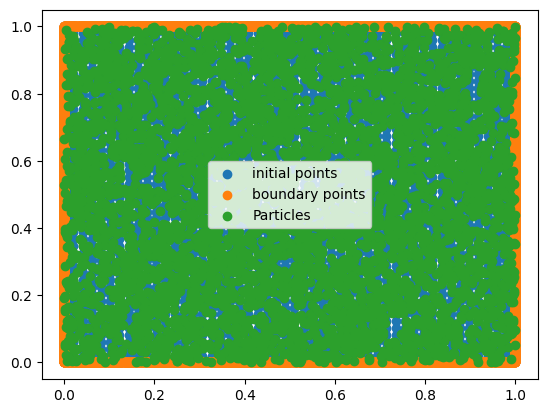

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Waves_2d'
######################################
# Load the data (wave 2d)
######################################
data = h5py.File('../../Problems/Wave/truth_2d.mat', 'r')
u_test = np.array(data['u'])
t_test = np.array(data['tgrid'])
x_test = np.array(data['xgrid'])
print(data.keys())
data.close()
#
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
xt_test = torch.tensor(
    np.concatenate([np.tile(x_test, (100,1)), t_test.repeat(505, axis=0)], axis=-1), dtype=dtype)
# ######################################
# # Generate training data
# ######################################
from Utils.GenPoints_Time import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
tT = 5.
Nx_center, Nt_center, N_init_mesh, N_bd_each_edge, Nt_bd = 1, 5000, 50, 5, 500
# #### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=Nx_center, nt=Nt_center, Rmax=1e-4, Rmin=1e-4, tT=[tT])
# #### (initial points)
xt_init = pointGen.init_point(nx_or_mesh=N_init_mesh, t_stamp=[0.], method='mesh')
# #### (boundary points)
xt_bd = pointGen.boundary_point(nx_each_edge=N_bd_each_edge, nt=Nt_bd, tT=[tT])
# #########################################
plt.figure()
plt.scatter(xt_init[:,0], xt_init[:,1], label='initial points')
plt.scatter(xt_bd[:,0], xt_bd[:,1], label='boundary points')
plt.scatter(xc_train[...,0], xc_train[...,1], label='Particles')
plt.legend()
plt.show()
# # #######
# from Utils.PlotFigure import Plot
# Plot.show_2d_list(xt_test[0:505], [u_test[0:505], u_test[-505:]], 
#                   ['u(x,y,t=0)', 'u(x,y,t=5)'], lb=0., ub=1.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, 
    dataType=dtype).get_testFun()

###############################
# The initial value f(x,y)
###############################
class Fun_f(object):

    def __init__(self):
        pass
        
    def __call__(self, xt):
        x, y = xt[...,0:1], xt[...,1:2]
        f = 4. * x**2 * y * (1.-x) * (1.-y)
        return f

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        '''Define the mollifer
        '''
        x, y = xt[...,0:1], xt[...,1:2]
        u = u * torch.sin(np.pi * x)*torch.sin(np.pi * y)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        #
        self.solver.getLoss = torch.nn.MSELoss()
        
    def Loss_pde(self, xc=None, tc=None):
        '''Define the PDE loss
        '''
        # ################################## 
        xc, tc, R = pointGen.weight_centers(n_center=1, nt=1000, Rmax=1e-4, Rmin=1e-4, tT=[tT])
        xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        t = tc.repeat(1, self.n_grid, 1)
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        t = Variable(t.reshape(-1, 1), requires_grad=True)
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        u = self.model_u(xt)
        u = self.mollifer(u, xt)
        du = self.solver.grad(u, [x, t])
        du_tt = self.solver.grad(du[1], [t])[0]
        #
        ddu_x = self.solver.grad(du[0][...,0:1], [x])[0]
        ddu_y = self.solver.grad(du[0][...,1:2], [x])[0]
        #
        du_xx = ddu_x[...,0:1]
        du_yy = ddu_y[...,1:2]
        ###########################################
        res1 = du_tt - (du_xx+du_yy)
        ###########################################
        loss = self.solver.getLoss(res1, torch.zeros_like(res1))
        
        return loss * 1.

    def Loss_bd(self):
        ''' '''
        loss = 0.
        ############### The initial condition
        xt = Variable(xt_init, requires_grad=True).to(self.device)
        u = self.model_u(xt)
        u = self.mollifer(u, xt)
        u_true = Fun_f()(xt)
        #
        dut = self.solver.grad(u, [xt])[0][...,2:]
        #
        loss += self.solver.getLoss(u, u_true)
        loss += self.solver.getLoss(dut, torch.zeros_like(dut))
        
        return loss * 1.
        
    def Error(self):
        ''' '''
        xt = xt_test.to(self.device)
        u = u_test.to(self.device)
        ####### 
        u_pred = self.model_u(xt)
        u_pred = self.mollifer(u_pred, xt)
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.PINN import PINN_Time
#
solver = PINN_Time.Solver(device, dtype=dtype)
model_u = solver.getModel([3, 40, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) Training and predicting

#### (3.1) Train the model

In [3]:
model_dict = {'u': model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, step_size=500)
solver.train(LossClass, xc_train, tc_train, batch_size_in=int(np.ceil(xc_train.shape[0]/50)), 
             w_pde=1., w_bd=10., epochs=2000, **{'save_path':f'saved_models/2d/'})
# solver.train_lbfgs(LossClass, xc_train, tc_train, R_train, epochs=100, 
#                    **{'save_path':f'saved_models/2d/'})

  5%|███▉                                                                           | 100/2000 [01:38<31:01,  1.02it/s]

Epoch:100 Time:98.4018, loss_in:0.001739, loss_bd:0.000037
          lr: 0.001 l2_err 0.14376918971538544


 10%|███████▉                                                                       | 200/2000 [03:16<29:15,  1.03it/s]

Epoch:200 Time:196.0974, loss_in:0.001082, loss_bd:0.000020
          lr: 0.001 l2_err 0.08217356353998184


 15%|███████████▊                                                                   | 300/2000 [04:53<27:48,  1.02it/s]

Epoch:300 Time:293.8566, loss_in:0.000253, loss_bd:0.000017
          lr: 0.001 l2_err 0.06720641255378723


 20%|███████████████▊                                                               | 400/2000 [06:31<26:11,  1.02it/s]

Epoch:400 Time:391.7512, loss_in:0.000192, loss_bd:0.000027
          lr: 0.001 l2_err 0.06354466825723648


 25%|███████████████████▊                                                           | 500/2000 [08:09<24:19,  1.03it/s]

Epoch:500 Time:489.3969, loss_in:0.000530, loss_bd:0.000022
          lr: 0.0005 l2_err 0.06553534418344498


 30%|███████████████████████▋                                                       | 600/2000 [09:46<22:52,  1.02it/s]

Epoch:600 Time:586.9322, loss_in:0.000099, loss_bd:0.000015
          lr: 0.0005 l2_err 0.05843653902411461


 35%|███████████████████████████▋                                                   | 700/2000 [11:26<21:05,  1.03it/s]

Epoch:700 Time:686.6124, loss_in:0.000054, loss_bd:0.000015
          lr: 0.0005 l2_err 0.057779695838689804


 40%|███████████████████████████████▌                                               | 800/2000 [13:04<19:31,  1.02it/s]

Epoch:800 Time:784.0791, loss_in:0.000059, loss_bd:0.000015
          lr: 0.0005 l2_err 0.057281043380498886


 45%|███████████████████████████████████▌                                           | 900/2000 [14:43<18:36,  1.01s/it]

Epoch:900 Time:883.4821, loss_in:0.000040, loss_bd:0.000014
          lr: 0.0005 l2_err 0.0570283979177475


 50%|███████████████████████████████████████                                       | 1000/2000 [16:16<15:00,  1.11it/s]

Epoch:1000 Time:976.3961, loss_in:0.000042, loss_bd:0.000015
          lr: 0.00025 l2_err 0.05831778421998024


 55%|██████████████████████████████████████████▉                                   | 1100/2000 [17:46<13:25,  1.12it/s]

Epoch:1100 Time:1066.2240, loss_in:0.000060, loss_bd:0.000015
          lr: 0.00025 l2_err 0.05650906264781952


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [19:18<12:56,  1.03it/s]

Epoch:1200 Time:1158.8888, loss_in:0.000027, loss_bd:0.000014
          lr: 0.00025 l2_err 0.05638885125517845


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [20:50<10:28,  1.11it/s]

Epoch:1300 Time:1250.3267, loss_in:0.000057, loss_bd:0.000015
          lr: 0.00025 l2_err 0.05656901374459267


 70%|██████████████████████████████████████████████████████▌                       | 1400/2000 [22:20<08:59,  1.11it/s]

Epoch:1400 Time:1340.1521, loss_in:0.000045, loss_bd:0.000014
          lr: 0.00025 l2_err 0.05611956864595413


 75%|██████████████████████████████████████████████████████████▌                   | 1500/2000 [23:52<07:38,  1.09it/s]

Epoch:1500 Time:1432.8100, loss_in:0.000070, loss_bd:0.000014
          lr: 0.000125 l2_err 0.05623907223343849


 80%|██████████████████████████████████████████████████████████████▍               | 1600/2000 [25:29<06:28,  1.03it/s]

Epoch:1600 Time:1529.9009, loss_in:0.000023, loss_bd:0.000014
          lr: 0.000125 l2_err 0.055872876197099686


 85%|██████████████████████████████████████████████████████████████████▎           | 1700/2000 [27:07<04:51,  1.03it/s]

Epoch:1700 Time:1627.4212, loss_in:0.000013, loss_bd:0.000014
          lr: 0.000125 l2_err 0.05569911375641823


 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [28:44<03:14,  1.03it/s]

Epoch:1800 Time:1724.9076, loss_in:0.000017, loss_bd:0.000014
          lr: 0.000125 l2_err 0.0556999109685421


 95%|██████████████████████████████████████████████████████████████████████████    | 1900/2000 [30:22<01:37,  1.02it/s]

Epoch:1900 Time:1822.4845, loss_in:0.000019, loss_bd:0.000014
          lr: 0.000125 l2_err 0.05570351332426071


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [31:59<00:00,  1.04it/s]

Epoch:2000 Time:1919.9949, loss_in:0.000039, loss_bd:0.000014
          lr: 6.25e-05 l2_err 0.055778343230485916
The total training time is 1920.0246


#### (3.2) Make prediction

The l2_err is tensor([0.0559])


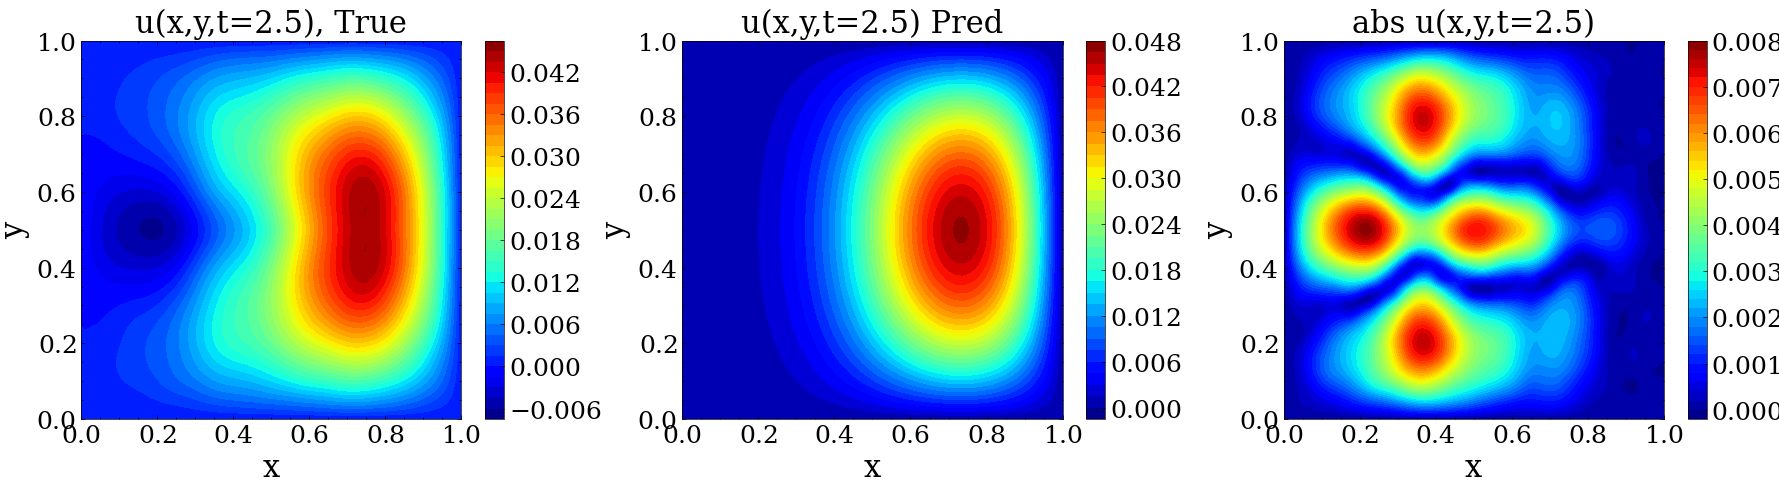

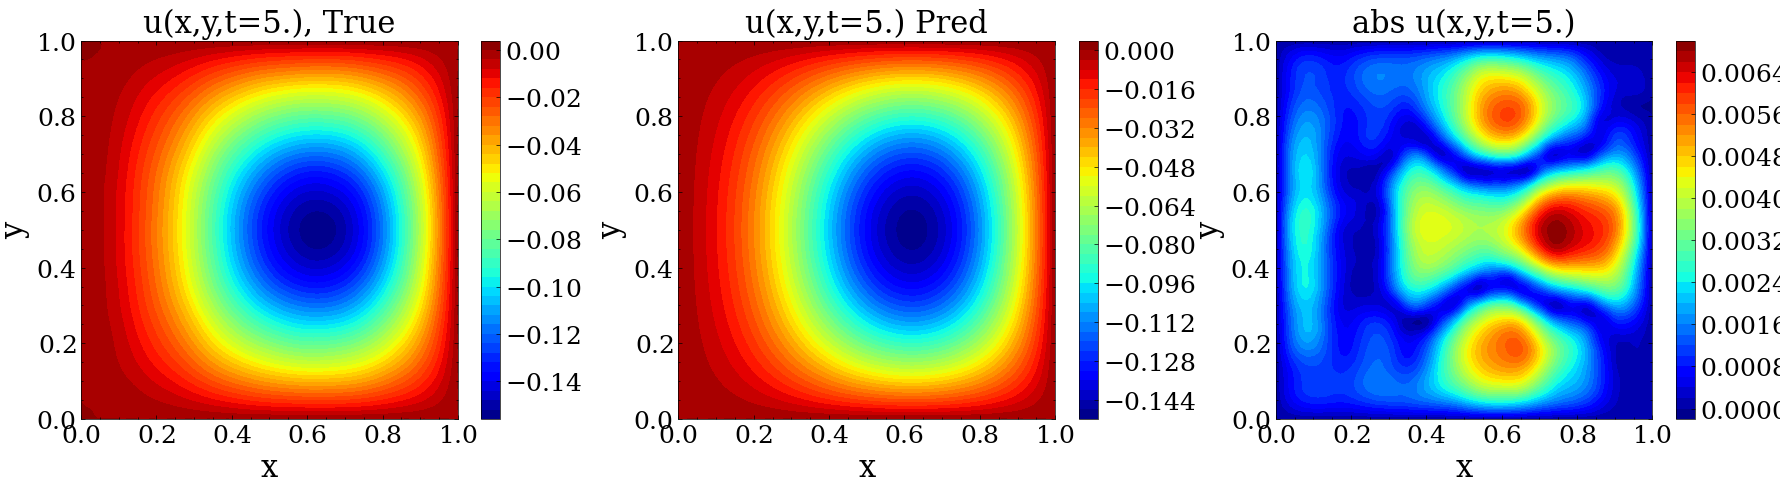

In [3]:
from torch.autograd import grad, Variable
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN_Time
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = PINN_Time.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/2d/', name='model_pinn_final')

###############################
# make prediction
###############################
xt_var = Variable(xt_test, requires_grad=True).to(device)
u_var = model_trained['u'](xt_var)
u_var = mollifer()(u_var, xt_var)
u_var = u_var.detach().cpu()
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(xt_test[505*50:505*51,0:2], 
                  [u_test[505*50:505*51], u_var[505*50:505*51], torch.abs(u_test[505*50:505*51]-u_var[505*50:505*51])], 
                  ['u(x,y,t=2.5), True', 'u(x,y,t=2.5) Pred', 'abs u(x,y,t=2.5)'], lb=0., ub=1.)
Plot.show_2d_list(xt_test[-505:,0:2], [u_test[-505:], u_var[-505:], torch.abs(u_test[-505:]-u_var[-505:])], 
                  ['u(x,y,t=5.), True', 'u(x,y,t=5.) Pred', 'abs u(x,y,t=5.)'], lb=0., ub=1.)